----------------

Volatility Pairs Trading Strategy

This notebook contains an analysis of implied volatility relationships between Bank Nifty and Nifty indices. The dataset used is a minute-level Options dataset which contains the Implied Volatilities of the 2 instruments along with their time to expiry. We take advantage of their correlation to build a medium frequency pair-trading strategy to profit off the spread between them.

Models used for trading strategy-

Base Model is a z-score based mean reversion strategy 
The second model is built using a Machine learning approach to outperform the Base Model

--------------------

We start off with importing some of the necessary libraries required

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.stattools import adfuller

In [2]:
import seaborn as sns
import statsmodels.api as sm

----------

Analysing and Cleaning the dataset

In [3]:
import pandas as pd
df = pd.read_parquet("/Users/sudhanvabharadwaj/Desktop/Interview_Practice/data.parquet", engine="fastparquet")

df

,banknifty,nifty,tte
time,,,
2021-01-01 09:15:00,0.286058,0.199729,27
2021-01-01 09:16:00,0.285381,0.200433,27
2021-01-01 09:17:00,0.284233,0.200004,27
2021-01-01 09:18:00,0.286104,0.199860,27
2021-01-01 09:19:00,0.285539,0.198951,27
...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28
2022-06-30 15:27:00,0.240875,0.216558,28
2022-06-30 15:28:00,0.242115,0.216794,28


In [ ]:
df[(df.index >= "2021-11-01") & (df.index <= "2022-01-01")]

,banknifty,nifty,tte
time,,,


In [ ]:
df

In [266]:
df.index

DatetimeIndex(['2021-01-01 09:15:00', '2021-01-01 09:16:00',
               '2021-01-01 09:17:00', '2021-01-01 09:18:00',
               '2021-01-01 09:19:00', '2021-01-01 09:20:00',
               '2021-01-01 09:21:00', '2021-01-01 09:22:00',
               '2021-01-01 09:23:00', '2021-01-01 09:24:00',
               ...
               '2022-06-30 15:21:00', '2022-06-30 15:22:00',
               '2022-06-30 15:23:00', '2022-06-30 15:24:00',
               '2022-06-30 15:25:00', '2022-06-30 15:26:00',
               '2022-06-30 15:27:00', '2022-06-30 15:28:00',
               '2022-06-30 15:29:00', '2022-06-30 15:30:00'],
              dtype='datetime64[ns]', name='time', length=690512, freq=None)

In [267]:
df.columns

Index(['banknifty', 'nifty', 'tte'], dtype='object')

In [268]:
df["tte"].nunique()

22

First, we check if for all the days in the dataset the trading time 9:30 to 15:30 is not exceeded

In [7]:
import pandas as pd

times = df.index.time

market_open = pd.to_datetime("09:15").time()
market_close = pd.to_datetime("15:30").time()

outside_hours = df[(times < market_open) | (times > market_close)]

print(len(outside_hours))
if len(outside_hours) > 0:
    display(outside_hours)


509656


,banknifty,nifty,tte
time,,,
2021-01-01 15:31:00,0.255651,0.178049,27
2021-01-01 15:32:00,0.255651,0.178049,27
2021-01-01 15:33:00,0.255651,0.178049,27
2021-01-01 15:34:00,0.255651,0.178049,27
2021-01-01 15:35:00,0.255651,0.178049,27
...,...,...,...
2022-06-30 09:10:00,0.243723,0.214376,29
2022-06-30 09:11:00,0.243723,0.214376,29
2022-06-30 09:12:00,0.243723,0.214376,29


509656 rows are outside of the allowed trading hours which means that we cannot move forward with them, since opening or closng positions at these times are not allowed and they will simply add noise to the model. But we will separate and keep them for future analysis or modelling to see how overnight changes might affect IV 

In [8]:
df['indian_hours'] = (
    (df.index.time >= pd.to_datetime("09:15:00").time()) &
    (df.index.time <= pd.to_datetime("15:30:00").time())
)

df['session_type'] = np.where(
    df['indian_hours'], 
    'trading', 
    'non_trading'
)


In [9]:
df

,banknifty,nifty,tte,indian_hours,session_type
time,,,,,
2021-01-01 09:15:00,0.286058,0.199729,27,True,trading
2021-01-01 09:16:00,0.285381,0.200433,27,True,trading
2021-01-01 09:17:00,0.284233,0.200004,27,True,trading
2021-01-01 09:18:00,0.286104,0.199860,27,True,trading
2021-01-01 09:19:00,0.285539,0.198951,27,True,trading
...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,True,trading
2022-06-30 15:27:00,0.240875,0.216558,28,True,trading
2022-06-30 15:28:00,0.242115,0.216794,28,True,trading


In [10]:
df_trading = df[df['session_type'] == 'trading'].copy()
df_no_trading = df[df['session_type'] == 'non_trading'].copy()

In [11]:
df_trading.drop(["indian_hours", "session_type"], axis = "columns", inplace=True)
df_no_trading.drop(["indian_hours", "session_type"], axis = "columns", inplace=True)


In [12]:
df_trading

,banknifty,nifty,tte
time,,,
2021-01-01 09:15:00,0.286058,0.199729,27
2021-01-01 09:16:00,0.285381,0.200433,27
2021-01-01 09:17:00,0.284233,0.200004,27
2021-01-01 09:18:00,0.286104,0.199860,27
2021-01-01 09:19:00,0.285539,0.198951,27
...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28
2022-06-30 15:27:00,0.240875,0.216558,28
2022-06-30 15:28:00,0.242115,0.216794,28


In [16]:
exists = ((df_trading.index >= "2021-11-01") & (df_trading.index <= "2022-01-01")).any()
exists

False

In [ ]:
exists = ((df_.index >= "2021-11-01") & (df.index <= "2022-01-01")).any()
exists

False

In [10]:
df_no_trading

,banknifty,nifty,tte
time,,,
2021-01-01 15:31:00,0.255651,0.178049,27
2021-01-01 15:32:00,0.255651,0.178049,27
2021-01-01 15:33:00,0.255651,0.178049,27
2021-01-01 15:34:00,0.255651,0.178049,27
2021-01-01 15:35:00,0.255651,0.178049,27
...,...,...,...
2022-06-30 09:10:00,0.243723,0.214376,29
2022-06-30 09:11:00,0.243723,0.214376,29
2022-06-30 09:12:00,0.243723,0.214376,29


Now we check if we have any missing values in the trading dataset so that when we later backtest, we do not end up with errors

In [11]:
df_trading.isna().sum()

banknifty    370
nifty        477
tte            0
dtype: int64

In [12]:
#Finding which rows have missing values

missing_rows = df_trading.isnull().any(axis=1)
missing_idx = df_trading.index[missing_rows]
missing_idx

DatetimeIndex(['2021-01-01 12:39:00', '2021-01-02 12:38:00',
               '2021-01-04 10:33:00', '2021-01-04 13:25:00',
               '2021-01-05 12:44:00', '2021-01-06 11:58:00',
               '2021-01-06 14:10:00', '2021-01-07 10:02:00',
               '2021-01-07 12:11:00', '2021-01-07 12:18:00',
               ...
               '2022-06-25 11:21:00', '2022-06-26 09:41:00',
               '2022-06-26 10:44:00', '2022-06-28 11:19:00',
               '2022-06-28 12:11:00', '2022-06-28 13:33:00',
               '2022-06-28 13:51:00', '2022-06-29 12:40:00',
               '2022-06-29 14:41:00', '2022-06-30 12:32:00'],
              dtype='datetime64[ns]', name='time', length=847, freq=None)

In [53]:
len(missing_idx)

847

In [58]:
df_trading.describe()

,banknifty,nifty,tte
count,180856.000000,180856.000000,180856.000000
mean,0.252428,0.180531,15.935639
std,0.058503,0.046373,8.699901
min,0.152732,0.089355,2.000000
25%,0.208084,0.141933,8.000000
50%,0.246823,0.181459,15.000000
75%,0.295293,0.217762,23.000000
max,0.460619,0.306952,31.000000


0.204% of values are missing for banknifty and 0.264% missing for nifty, which is very tiny. Forward filling is a very good choice given IV doesnt jump around and is not very volatile minute to minute as shown by the small standard deviations of both nifty and banknifty. Also given the small proportion of missing data, forward filling cannot heavily bias results.
Given what a small proportion of values are missing, dropping those rows is also a good option

In [13]:
df_trading = df_trading.ffill()


In [14]:
df_trading.isna().sum()

banknifty    0
nifty        0
tte          0
dtype: int64

-------------

EXPLORATORY DATA ANALYSIS

Since Time to Expiry is the same for both nifty and banknifty, the focus is first on understanding the behaviour and structure of the spread to check if the use of a mean-reverting strategy is a good option. If the TTE's were different for both instruments, we would have to consider spreads when the TTE's are similar for a robust strategy

In [280]:
df_trading

,banknifty,nifty,tte
time,,,
2021-01-01 09:15:00,0.286058,0.199729,27
2021-01-01 09:16:00,0.285381,0.200433,27
2021-01-01 09:17:00,0.284233,0.200004,27
2021-01-01 09:18:00,0.286104,0.199860,27
2021-01-01 09:19:00,0.285539,0.198951,27
...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28
2022-06-30 15:27:00,0.240875,0.216558,28
2022-06-30 15:28:00,0.242115,0.216794,28


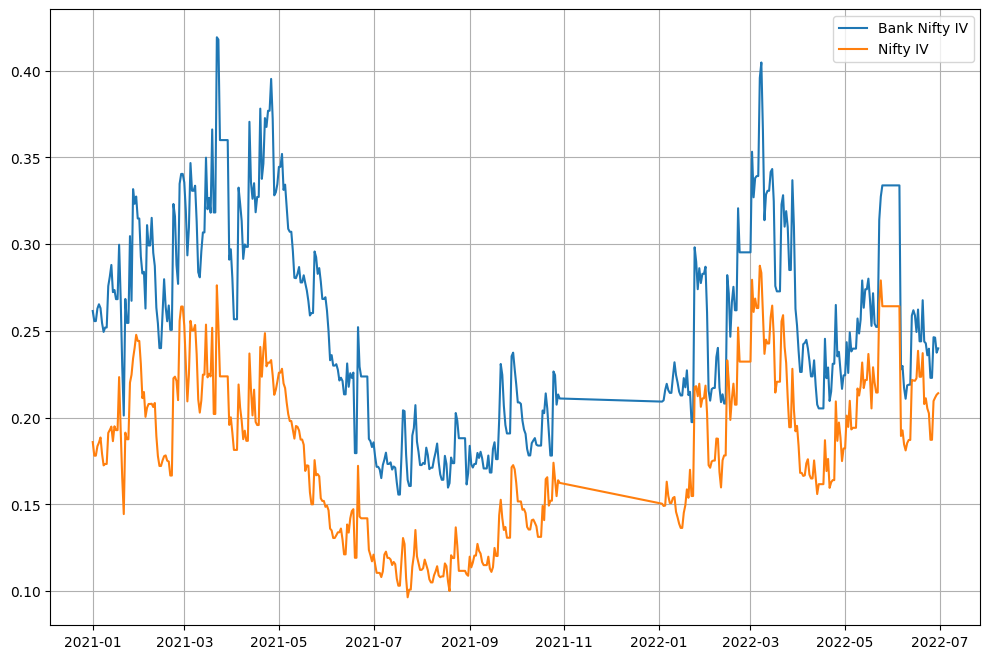

In [ ]:
#Plotting weekly and monthly values of the IVs over the whole time period to visualize and understand any underlying trends

import pandas as pd
import matplotlib.pyplot as plt

df_daily = df_trading.resample('D').mean().dropna()

plt.figure(figsize=(12, 8))
plt.plot(df_daily.index, df_daily['banknifty'], label='Bank Nifty IV')
plt.plot(df_daily.index, df_daily['nifty'], label='Nifty IV')
plt.legend()
plt.grid(True)
plt.show()

We can see from the graph that BANKNIFTY is more volatile and its Implied Volatilities are consistently higher than NIFTY IV. The paths of the 2 instruments look correlated and the spread between them is mainly positive

/var/folders/gx/p5qhhh8s7rg2_ywh443qwth80000gn/T/ipykernel_18096/3913936777.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_trading.resample('M').mean().dropna()


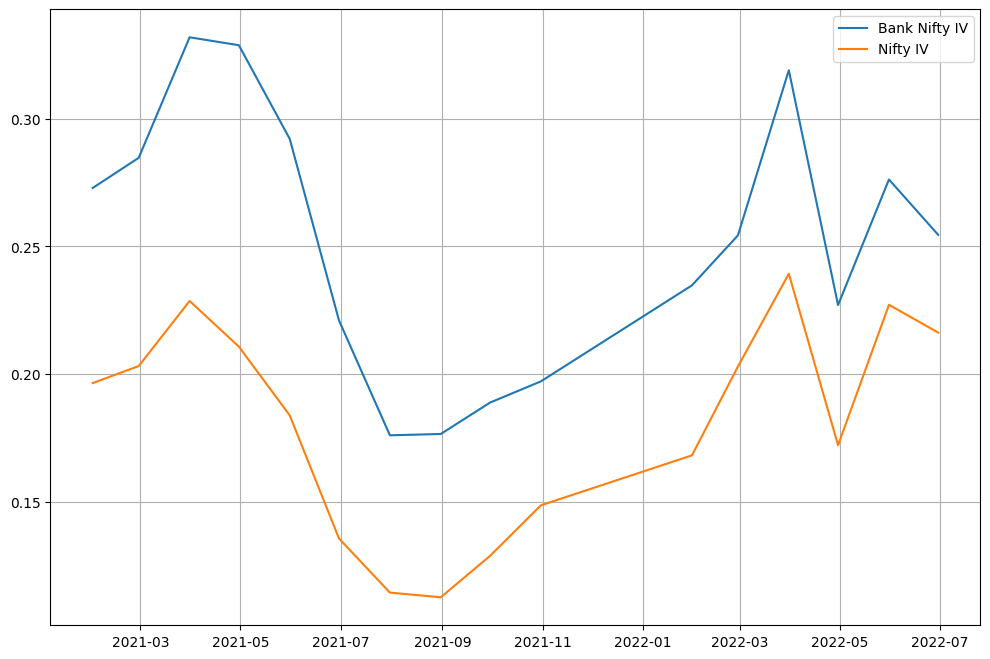

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_trading is your in-hours DataFrame with 'banknifty' and 'nifty'
df_monthly = df_trading.resample('M').mean().dropna()

plt.figure(figsize=(12, 8))
plt.plot(df_monthly.index, df_monthly['banknifty'], label='Bank Nifty IV')
plt.plot(df_monthly.index, df_monthly['nifty'], label='Nifty IV')
plt.legend()
plt.grid(True)
plt.show()

<Axes: title={'center': 'IV Spread'}, xlabel='time'>

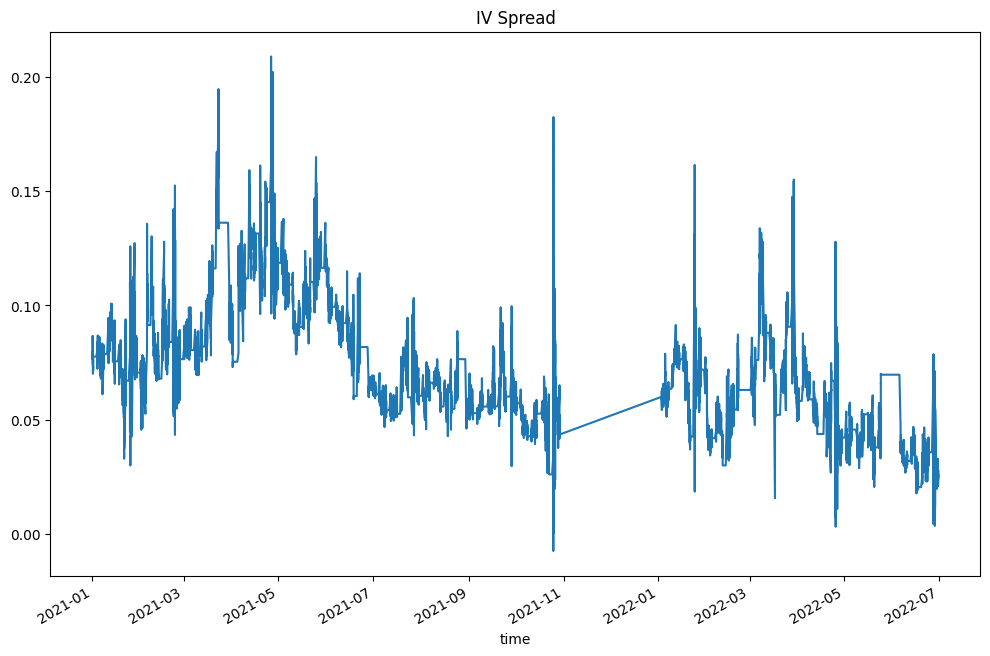

In [15]:
df_trading["spread"] = df_trading["banknifty"] - df_trading["nifty"]

plt.figure(figsize=(12,8))
df_trading["spread"].plot(title="IV Spread")

In [512]:
df_trading["spread"].describe()

count    180856.000000
mean          0.071897
std           0.026542
min          -0.007531
25%           0.054161
50%           0.067600
75%           0.085076
max           0.209056
Name: spread, dtype: float64

The spread plot tells a lot of important things-

1)There are a lot of sudden spikes sometimes upto 0.2

2)Its mainly positive, it reaches less than zero only at one small part

3)There are signs of mean reverting behaviour but its not across the whole timeframe, so performing some statistical tests is very important to conclude and move ahead

Statistical Distribution plots to better understand the underlying structure and distribution of the spread

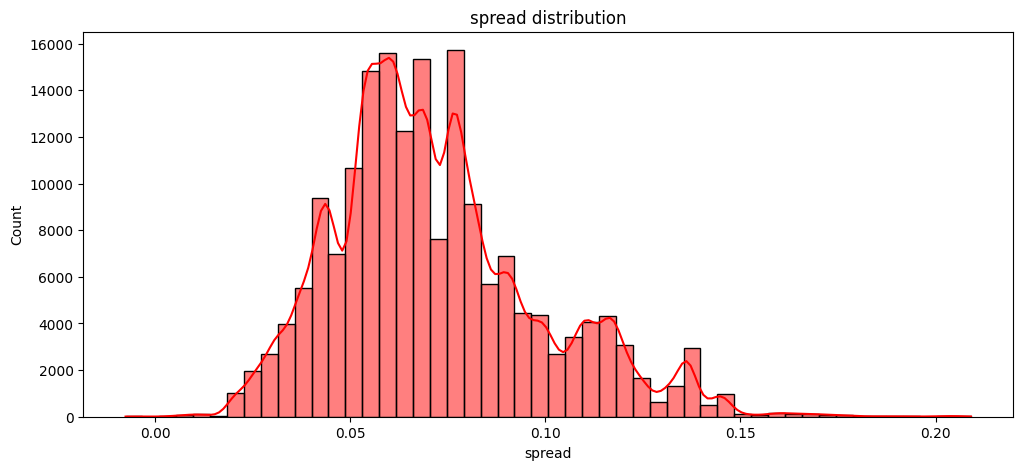

In [69]:
plt.figure(figsize=(12,5))
sns.histplot(df_trading['spread'], kde=True, bins=50, color='red')
plt.title("spread distribution")
plt.show()


This shows us that the IV spread is close to being normally distributed and relatively stable, showing potential as a good candidate for mean reverting strategy

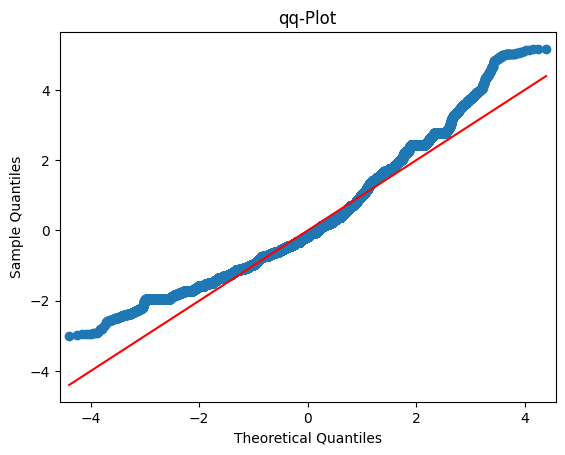

In [70]:
sm.qqplot(df_trading['spread'], line='s', fit=True)
plt.title("qq-Plot")
plt.show()

The QQ-Plot shows us that while majority of points stick close to the normal , at the end we have fat tails at the ends which could be due to sudden news or other shocks in the market which causes the spread to act differently. This is also in line with the histplot that was plotted above

In [71]:
skewness = df_trading['spread'].skew()
kurtosis = df_trading['spread'].kurtosis()
print(f"skewness: {skewness:.3f}, kurtosis: {kurtosis:.3f}")

skewness: 0.777, kurtosis: 0.607


The positive values for skewness and kurtosis confirm observations from all the previous plots

-------------

We use ACF(Autocorrelation Function) and PACF(Partial Autocorrelation Function) plots for a more robust check of mean reverting behaviour of the spread.

The ACF plots the correlation of the time series with itself at different lags. This helps us identify patterns such as seasonality and trends.

PACF plot shows the correlation of a time series with itself at different lags, after removing the effects of the previous lags. This helps us understand the direct relationship between observations at different lags.

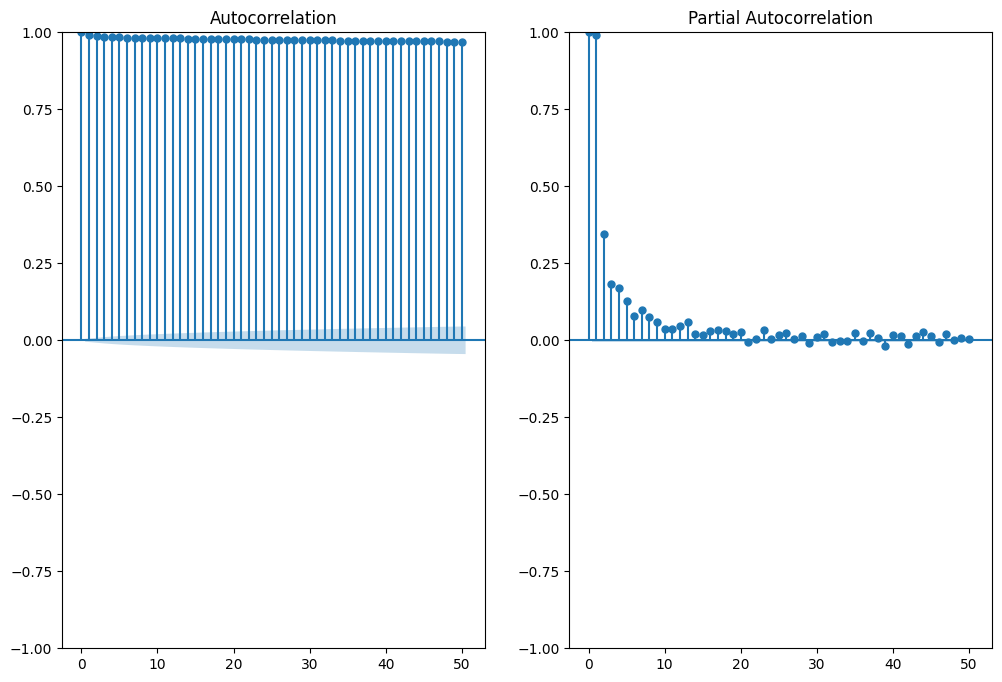

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(12,8))
sm.graphics.tsa.plot_acf(df_trading['spread'], lags=50, ax=axes[0])
sm.graphics.tsa.plot_pacf(df_trading['spread'], lags=50, ax=axes[1])
plt.show()

The ACF plot shows a an overall random walk like behaviour where it slowly decays. It is non-stationary.
From the PACF plot, we can see that the first difference has the highest significance, so differencing the time series by 1 could give us a series which is stationary and mean-reverting, which is what we require

In [16]:
df_trading['first_diff'] = df_trading['spread'].diff(periods=1)

df_trading.dropna(subset=['first_diff'], inplace=True)

<Axes: title={'center': 'IV Diff Spread'}, xlabel='time'>

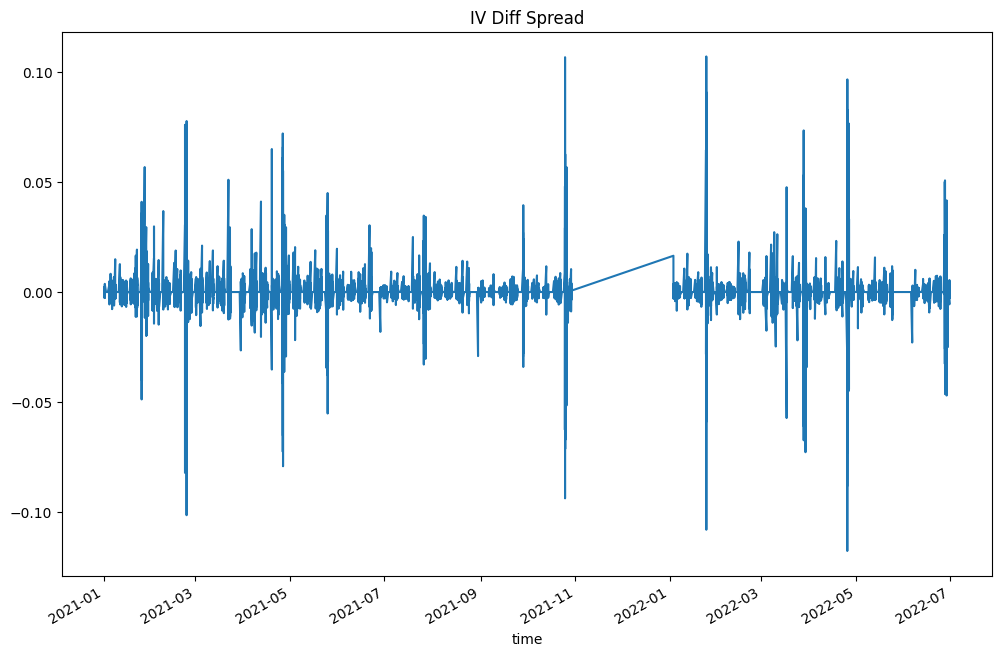

In [17]:
plt.figure(figsize=(12,8))
df_trading["first_diff"].plot(title="IV Diff Spread")

We can see from the above graph that the series df['first_diff'] is an ideal series for a mean reverting strategy. For a more robust and statistical confirmation before we build a strategy, we plot ACF and PACF of df['first_diff']

<Figure size 1200x600 with 0 Axes>

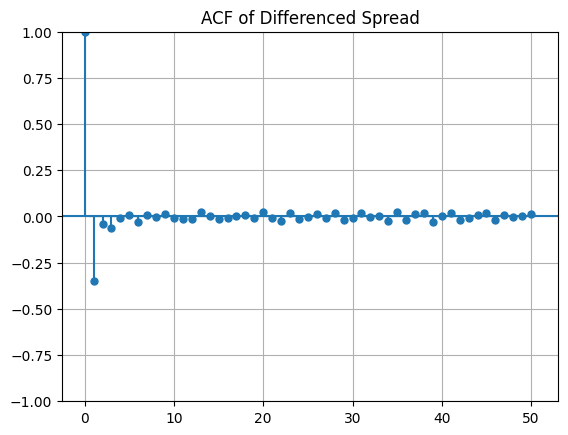

<Figure size 1200x600 with 0 Axes>

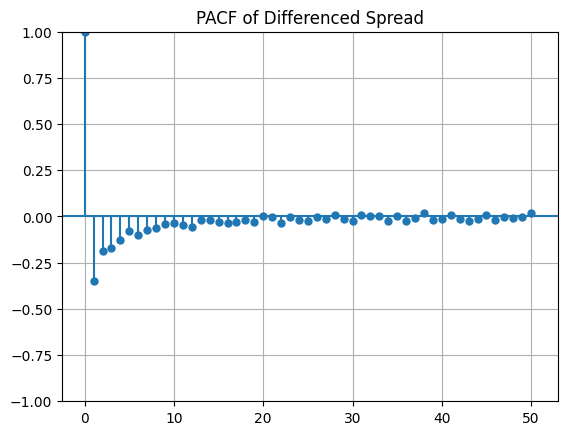

In [132]:
plt.figure(figsize=(12, 6))
sm.graphics.tsa.plot_acf(df_trading['first_diff'], lags=50, title='ACF of Differenced Spread')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(df_trading['first_diff'], lags=50, title='PACF of Differenced Spread')
plt.grid(True)
plt.show()

We can see from the ACF plot that the autocorrelation drops very quickly and the values are no longer slowly trending downwards. In both ACF and PACF we can clearly see that the strong lag at 1 is removed, which shows stationarity and its slightly negative which is an indication of mean reverting. We make use of the ADF(Augmented Dickey-Fuller) test as the final step to figure out whether it rejects non-stationarity

In [133]:
#Stationarity check using Augmented Dickey-Fuller test

from statsmodels.tsa.stattools import adfuller
adf_stat, p_value = adfuller(df_trading["first_diff"])[:2]

In [134]:
print("p value is: ", p_value)
print(adf_stat)

p value is:  0.0
-59.08165328752763


ADF test strongly rejects non-stationarity (p < 0.001), which confirms that the differenced spread is stationary and suitable for mean reversion modeling. So now we can confidently move on to build a mean reverting strategy by making use of df["first_diff]

In [516]:
df_trading["first_diff"].describe()

count    1.808550e+05
mean    -3.345332e-07
std      3.645995e-03
min     -1.178485e-01
25%     -2.115000e-04
50%      0.000000e+00
75%      2.005000e-04
max      1.072130e-01
Name: first_diff, dtype: float64

--------------------------

Building a Backtesting Class to test the z-score strategy. We assume here that we start off with an inital capital of 0 Rupees

In [537]:
class Backtester:
    def __init__(self, df, transaction_cost=0.003, slippage=0.001):
        self.df = df.copy()
        self.transaction_cost = transaction_cost
        self.slippage = slippage

    #Function to calculate zscores
    def zscores(self, window):
        
        col_names = {
        "mean": f"mean_{window}",
        "std": f"std_{window}",
        "z": f"z_{window}"
        }

        self.df[col_names["mean"]] = self.df['first_diff'].rolling(window).mean().shift(1)
        self.df[col_names["std"]] = self.df['first_diff'].rolling(window).std().shift(1)
        self.df[col_names["z"]] = (
            (self.df['first_diff'] - self.df[col_names["mean"]]) / self.df[col_names["std"]]
        )
        
        return self.df

    # A run strategy function that directly makes use of the spread to backtest instead of maintaining separate positions
    def run_strategy(self, window, entry_z, exit_z):

        df = self.zscores(window).dropna()

        banknifty_pos, nifty_pos = 0, 0
        entry_spread, entry_tte = 0, 0
        realized_pnl = 0
        pnl_curve = []
        trade_pnls = []

        for i, row in df.iterrows():
            z_score = row[f'z_{window}']
            
            # This enters a short spread position
            if banknifty_pos == 0 and z_score > entry_z:
                banknifty_pos, nifty_pos = -1, 1
                entry_spread, entry_tte = row['spread'], row['tte']
                realized_pnl -= 2 * (self.transaction_cost + self.slippage)

            # This enters a short spread position
            elif banknifty_pos == 0 and z_score < -entry_z:
                banknifty_pos, nifty_pos = 1, -1
                entry_spread, entry_tte = row['spread'], row['tte']
                realized_pnl -= 2 * (self.transaction_cost + self.slippage)

            # Exit a position and calculate profit based on specified formula
            elif banknifty_pos != 0 and abs(z_score) < exit_z:
                exit_value = (row['spread'] * (row['tte'] ** 0.7))
                entry_value = (entry_spread * (entry_tte ** 0.7))
                trade_pnl = exit_value - entry_value

                if banknifty_pos == 1: 
                    realized_pnl += trade_pnl
                else:                 
                    realized_pnl -= trade_pnl

                trade_pnls.append(trade_pnl)
                banknifty_pos = nifty_pos = 0
                entry_spread, entry_tte = 0, 0
            
            # Unrealised pnl is accurate analysis of the equity curve
            unrealized_pnl = 0
            if banknifty_pos != 0:
                current_value = (row['spread'] * (row['tte'] ** 0.7))
                entry_value = (entry_spread * (entry_tte ** 0.7))
                unrealized_pnl = current_value - entry_value
                if banknifty_pos == -1: 
                    unrealized_pnl = -unrealized_pnl

            equity_value = realized_pnl + unrealized_pnl
            pnl_curve.append(equity_value)

        return pd.Series(pnl_curve, index=df.index), realized_pnl, len(trade_pnls), trade_pnls

    def evaluate(self, pnl_series, trade_pnls=None):
        
        #resample to get a better/more comprehensive way to calculate sharpe 
        daily_returns = pnl_series.resample("1D").last().diff().dropna()
        sharpe_daily = 0
        if daily_returns.std() != 0:
            sharpe_daily = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)

        return {
            "sharpe_per_bar": sharpe_daily,
            "final_pnl": pnl_series.iloc[-1],
            "max_drawdown": self.max_drawdown(pnl_series),
            "num_trades": len(trade_pnls) if trade_pnls else 0
        }

    @staticmethod
    def max_drawdown(pnl_series):
        cummax = pnl_series.cummax()
        drawdown = pnl_series - cummax
        return -drawdown.min()

In [541]:
backtester = Backtester(df_trading)
pnl_curve, cum_pnl, trade_count, trade_pnls = backtester.run_strategy(window=60, entry_z=2, exit_z=0.5)
metrics = backtester.evaluate(pnl_curve, trade_pnls)
print(metrics)


{'sharpe_per_bar': 0.6053696642374096, 'final_pnl': 25.800385078621268, 'max_drawdown': 6.962275093758515, 'num_trades': 5330}


------------------------------

The above code is for a specific example, but given that there is a wide range of values for entry, exit, window that could significantly improve performance, the next class adds on with a grid search function

In [520]:
class Backtester:
    def __init__(self, df, transaction_cost=0.003, slippage=0.001):
        self.df = df.copy()
        self.transaction_cost = transaction_cost
        self.slippage = slippage

    #Function to calculate zscores
    def zscores(self, window):
        
        col_names = {
        "mean": f"mean_{window}",
        "std": f"std_{window}",
        "z": f"z_{window}"
        }

        self.df[col_names["mean"]] = self.df['first_diff'].rolling(window).mean().shift(1)
        self.df[col_names["std"]] = self.df['first_diff'].rolling(window).std().shift(1)
        self.df[col_names["z"]] = (
            (self.df['first_diff'] - self.df[col_names["mean"]]) / self.df[col_names["std"]]
        )
        
        return self.df

    def run_strategy(self, window, entry_z, exit_z):

        df = self.zscores(window).dropna()

        banknifty_pos, nifty_pos = 0, 0
        entry_spread, entry_tte = 0, 0
        realized_pnl = 0
        pnl_curve = []
        trade_pnls = []

        for i, row in df.iterrows():
            z_score = row[f'z_{window}']

            if banknifty_pos == 0 and z_score > entry_z:
                banknifty_pos, nifty_pos = -1, 1
                entry_spread, entry_tte = row['spread'], row['tte']
                realized_pnl -= 2 * (self.transaction_cost + self.slippage)

            elif banknifty_pos == 0 and z_score < -entry_z:
                banknifty_pos, nifty_pos = 1, -1
                entry_spread, entry_tte = row['spread'], row['tte']
                realized_pnl -= 2 * (self.transaction_cost + self.slippage)

            elif banknifty_pos != 0 and abs(z_score) < exit_z:
                exit_value = (row['spread'] * (row['tte'] ** 0.7))
                entry_value = (entry_spread * (entry_tte ** 0.7))
                trade_pnl = exit_value - entry_value

                if banknifty_pos == 1: 
                    realized_pnl += trade_pnl
                else:                 
                    realized_pnl -= trade_pnl

                trade_pnls.append(trade_pnl)
                banknifty_pos = nifty_pos = 0
                entry_spread, entry_tte = 0, 0

            unrealized_pnl = 0
            if banknifty_pos != 0:
                current_value = (row['spread'] * (row['tte'] ** 0.7))
                entry_value = (entry_spread * (entry_tte ** 0.7))
                unrealized_pnl = current_value - entry_value
                if banknifty_pos == -1: 
                    unrealized_pnl = -unrealized_pnl

            equity_value = realized_pnl + unrealized_pnl
            pnl_curve.append(equity_value)

        return pd.Series(pnl_curve, index=df.index), realized_pnl, len(trade_pnls), trade_pnls

    def evaluate(self, pnl_series, trade_pnls=None):
        daily_returns = pnl_series.resample("1D").last().diff().dropna()
        sharpe_daily = 0
        if daily_returns.std() != 0:
            sharpe_daily = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)

        return {
            "sharpe_per_bar": sharpe_daily,
            "final_pnl": pnl_series.iloc[-1],
            "max_drawdown": self.max_drawdown(pnl_series),
            "num_trades": len(trade_pnls) if trade_pnls else 0
        }

    @staticmethod
    def max_drawdown(pnl_series):
        cummax = pnl_series.cummax()
        drawdown = pnl_series - cummax
        return -drawdown.min()
    
    #This function is used for grid-searching different paramenter(window, entry and exit)
    def grid_search(self, window_range, entry_z_range, exit_z_range):
        
        results = []

        for window in window_range:
            for entry_z in entry_z_range:
                for exit_z in exit_z_range:
                    pnl_series, cum_pnl, num_trades, trade_pnls = self.run_strategy(window, entry_z, exit_z)
                    metrics = self.evaluate(pnl_series, trade_pnls)
                    results.append({
                            "window": window,
                            "entry_z": entry_z,
                            "exit_z": exit_z,
                            **metrics
                    })

        results_df = pd.DataFrame(results)
        return results_df


In [521]:
cutoff_date = "2022-01-01" 
train_df = df_trading.loc[:cutoff_date]
test_df = df_trading.loc[cutoff_date:]


In [523]:
bt = Backtester(train_df)
results = bt.grid_search(window_range=[30, 60, 200, 600, 850, 1000, 1400, 1875], entry_z_range=[1, 1.5, 2, 2.5], exit_z_range=[0.5, 0.7, 1, 1.5])
results.sort_values("sharpe_per_bar", ascending=False).head()

,window,entry_z,exit_z,sharpe_per_bar,final_pnl,max_drawdown,num_trades
44,200,2.5,0.5,2.513680,11.315805,3.732429,1752
45,200,2.5,0.7,2.147877,11.063898,3.704099,1819
46,200,2.5,1.0,2.107142,9.364596,4.505997,1891
76,850,2.5,0.5,1.861642,29.777925,4.115316,2367
92,1000,2.5,0.5,1.836121,37.588216,4.112718,2470


In [524]:
results.sort_values("final_pnl", ascending=False)

,window,entry_z,exit_z,sharpe_per_bar,final_pnl,max_drawdown,num_trades
108,1400,2.5,0.5,1.798399,38.424096,3.272519,2512
92,1000,2.5,0.5,1.836121,37.588216,4.112718,2470
120,1875,2.0,0.5,1.479278,36.978966,5.669047,3673
124,1875,2.5,0.5,1.626960,35.909974,5.295150,2491
121,1875,2.0,0.7,1.204709,33.943809,7.561906,3899
...,...,...,...,...,...,...,...
114,1875,1.0,1.0,-1.773871,-15.016140,35.696145,10925
99,1400,1.0,1.5,-1.425903,-15.024307,35.125886,11876
83,1000,1.0,1.5,-1.936435,-16.050146,32.932303,11847
3,30,1.0,1.5,-2.833136,-16.765228,40.727410,13750


Making use of only one metric like Sharpe or PnL or Drawdown by themselves would be a mistake. For example - A strategy with a high PnL but low sharpe and a big drawdown would be a very volatile one, the risk for reward isnt high and having to sit through a long, big drawdown is not ideal. Additionally it would probably not generalize well to new data.

A good strategy should strike a balance between all 3 metrics, so the next step is to normalize the values and use a weighting function and 
get an overall score.

In [525]:
results_copy = results.copy()

In [526]:
results_copy

,window,entry_z,exit_z,sharpe_per_bar,final_pnl,max_drawdown,num_trades
0,30,1.0,0.5,-1.530067,-2.728367,26.950186,10876
1,30,1.0,0.7,-1.796244,-5.931193,29.423419,11897
2,30,1.0,1.0,-1.812708,-11.634759,32.765092,12855
3,30,1.0,1.5,-2.833136,-16.765228,40.727410,13750
4,30,1.5,0.5,-0.826325,5.205035,16.340451,6648
...,...,...,...,...,...,...,...
123,1875,2.0,1.5,1.082781,31.316715,7.841251,4353
124,1875,2.5,0.5,1.626960,35.909974,5.295150,2491
125,1875,2.5,0.7,1.410029,29.371925,7.672545,2617
126,1875,2.5,1.0,1.282165,28.504836,6.766581,2737


In [527]:
results_copy[['sharpe_per_bar', 'final_pnl']] = results_copy[['sharpe_per_bar', 'final_pnl']].apply(lambda col: (col / col.max()) * 100)

results_copy['max_drawdown'] = (1 - (results_copy['max_drawdown'] / results_copy['max_drawdown'].max())) * 100


We give Sharpe ratio receives the highest weight (40%) as it is the biggest indicator of risk-adjusted performance. Final PnL and maximum drawdown are equally weighted (30% each) to balance return generated with risk management , giving us a well-rounded strategy based on multiple performance metrics

In [528]:
w_sharpe = 0.4
w_pnl = 0.3
w_drawdown = 0.3
results_copy["score"] = (results_copy["sharpe_per_bar"]* w_sharpe) + (results_copy["final_pnl"] * w_pnl) + (results_copy["max_drawdown"] * w_drawdown)

In [529]:
results_copy.sort_values("score", ascending=False)

,window,entry_z,exit_z,sharpe_per_bar,final_pnl,max_drawdown,num_trades,score
108,1400,2.5,0.5,71.544488,100.000000,91.964825,2512,86.207243
92,1000,2.5,0.5,73.045163,97.824594,89.901842,2470,85.535996
124,1875,2.5,0.5,64.724238,93.456912,86.998559,2491,80.026336
76,850,2.5,0.5,74.060436,77.498051,89.895463,2367,79.842229
120,1875,2.0,0.5,58.849098,96.239001,86.080513,3673,78.235493
...,...,...,...,...,...,...,...,...
114,1875,1.0,1.0,-70.568719,-39.080008,12.353511,10925,-36.245437
83,1000,1.0,1.5,-77.035858,-41.771045,19.139709,11847,-37.603744
66,850,1.0,1.0,-83.224179,-37.450349,21.024471,10830,-38.217435
115,1875,1.0,1.5,-75.524484,-46.152629,5.469671,11744,-42.414681


A lot of important observations can be made from this graph-

1)Longer window sizes are better suited

2)Very small entry and exit z values lead to too many trades being taken, without any proper mean reverting structure exploited, leading to a lot of trades being made and PnL being very low

3)A balanced mix of entry and exit z-values, longer window helps to get the best results

In [542]:
results.iloc[108]

window            1400.000000
entry_z              2.500000
exit_z               0.500000
sharpe_per_bar       1.798399
final_pnl           38.424096
max_drawdown         3.272519
num_trades        2512.000000
Name: 108, dtype: float64

Now, using the metrics that had the best weigthed score, on the test dataframe for a more comprehensive evaluation of the strategy and parameters

In [532]:
backtester = Backtester(test_df)
pnl_curve, cum_pnl, trade_count, trade_pnls = backtester.run_strategy(window=1400, entry_z=2.5, exit_z=0.5)
metrics = backtester.evaluate(pnl_curve, trade_pnls)
print(metrics)


{'sharpe_per_bar': 2.7891330686768896, 'final_pnl': 29.24421912127185, 'max_drawdown': 2.0635237344155435, 'num_trades': 1442}


Making use of the optimal parameters from the scoring, the results are good. Pnl is 29.244 Rupees, Shapre is 2.789 and Drawdown is 2.06 Rupees( We start off at 0 Rupees) 

----------------------


In [436]:
df_trading

,banknifty,nifty,tte,spread,first_diff,minute_day
time,,,,,,
2021-01-01 09:16:00,0.285381,0.200433,27,0.084948,-0.001381,556
2021-01-01 09:17:00,0.284233,0.200004,27,0.084229,-0.000719,557
2021-01-01 09:18:00,0.286104,0.199860,27,0.086244,0.002015,558
2021-01-01 09:19:00,0.285539,0.198951,27,0.086588,0.000344,559
2021-01-01 09:20:00,0.283431,0.198716,27,0.084715,-0.001873,560
...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,0.025943,0.000781,926
2022-06-30 15:27:00,0.240875,0.216558,28,0.024317,-0.001626,927
2022-06-30 15:28:00,0.242115,0.216794,28,0.025321,0.001004,928


The current z-score model is static, the entry and exit thresholds are fixed. While this may work well, markets are very volatile so adapting entry and exit to changing market conditions can improve performace. Also mean reversion strategies can suffer when there is one long one-sided trend, so adding a trend filter can help

In [546]:
class Backtester:
    
    def __init__(self, df, transaction_cost=0.003, slippage=0.001):
        self.df = df.copy()
        self.transaction_cost = transaction_cost
        self.slippage = slippage

    # Function to calculate z-scores
    def zscores(self, window):

        col_names = {
            "mean": f"mean_{window}",
            "std": f"std_{window}",
            "z": f"z_{window}"
        }

        self.df[col_names["mean"]] = self.df['first_diff'].rolling(window).mean().shift(1)
        self.df[col_names["std"]] = self.df['first_diff'].rolling(window).std().shift(1)
        self.df[col_names["z"]] = (
            (self.df['first_diff'] - self.df[col_names["mean"]]) / self.df[col_names["std"]]
        )
        
        return self.df

    def run_strategy(self, window, entry_z, exit_z, trend_window):

        df = self.zscores(window).dropna()
        
        #Making use of a long-term moving average to act as a trend filter.
        df['trend_ma'] = df['first_diff'].rolling(trend_window).mean().shift(1)
        
        # A rolling standard deviation of the z-scores to make entry/exit thresholds dynamic and adaptive
        df['rolling_z_std'] = df[f'z_{window}'].rolling(window).std().shift(1)
        
        df = df.dropna()

        banknifty_pos, nifty_pos = 0, 0
        entry_spread, entry_tte = 0, 0
        realized_pnl = 0
        pnl_curve = []
        trade_pnls = []

        for i, row in df.iterrows():
            z_score = row[f'z_{window}']
            
            #The dynamic thresholds
            dynamic_entry_z = entry_z * row['rolling_z_std']
            dynamic_exit_z = exit_z * row['rolling_z_std']

            # Checking if the current spread is far from its long-term average
            is_trending = abs(row['first_diff'] - row['trend_ma']) > 0.05

            # We only enter a short spread position if it's not trending
            if banknifty_pos == 0 and z_score > dynamic_entry_z and not is_trending:
                banknifty_pos, nifty_pos = -1, 1
                entry_spread, entry_tte = row['spread'], row['tte']
                realized_pnl -= 2 * (self.transaction_cost + self.slippage)

            # We only enter a long spread position only if it's not trending
            elif banknifty_pos == 0 and z_score < -dynamic_entry_z and not is_trending:
                banknifty_pos, nifty_pos = 1, -1
                entry_spread, entry_tte = row['spread'], row['tte']
                realized_pnl -= 2 * (self.transaction_cost + self.slippage)

            elif banknifty_pos != 0 and abs(z_score) < dynamic_exit_z:
                exit_value = (row['spread'] * (row['tte'] ** 0.7))
                entry_value = (entry_spread * (entry_tte ** 0.7))
                trade_pnl = exit_value - entry_value

                if banknifty_pos == 1: 
                    realized_pnl += trade_pnl
                else:                 
                    realized_pnl -= trade_pnl

                trade_pnls.append(trade_pnl)
                banknifty_pos = nifty_pos = 0
                entry_spread, entry_tte = 0, 0

            unrealized_pnl = 0
            if banknifty_pos != 0:
                current_value = (row['spread'] * (row['tte'] ** 0.7))
                entry_value = (entry_spread * (entry_tte ** 0.7))
                unrealized_pnl = current_value - entry_value
                if banknifty_pos == -1: 
                    unrealized_pnl = -unrealized_pnl

            equity_value = realized_pnl + unrealized_pnl
            pnl_curve.append(equity_value)

        return pd.Series(pnl_curve, index=df.index), realized_pnl, len(trade_pnls), trade_pnls

    def evaluate(self, pnl_series, trade_pnls=None):
        daily_returns = pnl_series.resample("1D").last().diff().dropna()
        sharpe_daily = 0
        if daily_returns.std() != 0:
            sharpe_daily = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)

        return {
            "sharpe_per_bar": sharpe_daily,
            "final_pnl": pnl_series.iloc[-1],
            "max_drawdown": self.max_drawdown(pnl_series),
            "num_trades": len(trade_pnls) if trade_pnls else 0
        }

    @staticmethod
    def max_drawdown(pnl_series):
        cummax = pnl_series.cummax()
        drawdown = pnl_series - cummax
        return -drawdown.min()
    
    def grid_search(self, window_range, entry_z_range, exit_z_range, trend_window_range):

        results = []

        for window in window_range:
            for entry_z in entry_z_range:
                for exit_z in exit_z_range:
                    for trend_window in trend_window_range:
                        pnl_series, cum_pnl, num_trades, trade_pnls = self.run_strategy(window, entry_z, exit_z, trend_window)
                        metrics = self.evaluate(pnl_series, trade_pnls)
                        results.append({
                            "window": window,
                            "entry_z": entry_z,
                            "exit_z": exit_z,
                            "trend_window": trend_window,
                            **metrics
                        })

        results_df = pd.DataFrame(results)
        return results_df



In [548]:
bt = Backtester(train_df)
results = bt.grid_search(window_range=[30, 60, 100, 200, 320, 600, 850, 1000, 1200, 1400, 1875], entry_z_range=[1, 1.5, 2, 2.5, 3], exit_z_range=[0.5, 0.7, 1, 1.3, 1.6, 2], trend_window_range=[200, 300, 400, 650, 800, 920, 1200])
results.sort_values("sharpe_per_bar", ascending=False).head()

,window,entry_z,exit_z,trend_window,sharpe_per_bar,final_pnl,max_drawdown,num_trades
1448,850,3.0,1.0,1200,4.302770,6.205099,1.980647,765
1442,850,3.0,1.0,200,4.238948,6.205099,1.980647,765
1443,850,3.0,1.0,300,4.238948,6.205099,1.980647,765
1444,850,3.0,1.0,400,4.238948,6.205099,1.980647,765
1445,850,3.0,1.0,650,4.238948,6.205099,1.980647,765


In [549]:
results.sort_values("final_pnl", ascending=False).head()

,window,entry_z,exit_z,trend_window,sharpe_per_bar,final_pnl,max_drawdown,num_trades
2149,1875,1.5,0.7,200,-1.232412,15.062822,8.198693,3872
2143,1875,1.5,0.5,300,-0.900127,14.840521,7.944042,3655
2144,1875,1.5,0.5,400,-0.900127,14.840521,7.944042,3655
2145,1875,1.5,0.5,650,-0.900127,14.840521,7.944042,3655
2146,1875,1.5,0.5,800,-0.900127,14.840521,7.944042,3655


In [550]:
results_copy = results.copy()

In [551]:
results_copy[['sharpe_per_bar', 'final_pnl']] = results_copy[['sharpe_per_bar', 'final_pnl']].apply(lambda col: (col / col.max()) * 100)

results_copy['max_drawdown'] = (1 - (results_copy['max_drawdown'] / results_copy['max_drawdown'].max())) * 100

w_sharpe = 0.4
w_pnl = 0.3
w_drawdown = 0.3
results_copy["score"] = (results_copy["sharpe_per_bar"]* w_sharpe) + (results_copy["final_pnl"] * w_pnl) + (results_copy["max_drawdown"] * w_drawdown)

results_copy.sort_values("score", ascending=False)

,window,entry_z,exit_z,trend_window,sharpe_per_bar,final_pnl,max_drawdown,num_trades,score
1455,850,3.0,1.3,1200,92.146123,53.532839,96.916798,797,81.993340
1453,850,3.0,1.3,800,90.854361,53.532839,96.916798,797,81.476635
1449,850,3.0,1.3,200,90.854361,53.532839,96.916798,797,81.476635
1450,850,3.0,1.3,300,90.854361,53.532839,96.916798,797,81.476635
1451,850,3.0,1.3,400,90.854361,53.532839,96.916798,797,81.476635
...,...,...,...,...,...,...,...,...,...
26,30,1.0,1.3,920,-98.900133,-222.320810,7.691894,12471,-103.948728
25,30,1.0,1.3,800,-98.900133,-222.886525,7.520052,12492,-104.169995
24,30,1.0,1.3,650,-99.544685,-223.461490,7.337696,12514,-104.655012
23,30,1.0,1.3,400,-99.544685,-225.414981,6.688109,12555,-105.435936


In [553]:
backtester = Backtester(test_df)
pnl_curve, cum_pnl, trade_count, trade_pnls = backtester.run_strategy(window=1455, entry_z=3, exit_z=1.3, trend_window=1200)
metrics = backtester.evaluate(pnl_curve, trade_pnls)
print(metrics)

{'sharpe_per_bar': 0.7747168510836892, 'final_pnl': 2.344443297463861, 'max_drawdown': 2.8431393563721024, 'num_trades': 766}


Before exploring ML techniques, I tested traditional strategy enhancements including dynamic thresholds and trend filtering. These modifications could potentially have helped, but as seen from the results above, they did not outperform the base model, leading me to the conclusion that for highly mean-reverting spreads, a simple statistical arbitrage strategy remains a better option.

Over-adapting entry and exit rules introduced noise, delayed signal execution, and filtered out profitable trades. 

-----------------------------

Building a Machine Learning Model

In [18]:
df_trading

,banknifty,nifty,tte,spread,first_diff
time,,,,,
2021-01-01 09:16:00,0.285381,0.200433,27,0.084948,-0.001381
2021-01-01 09:17:00,0.284233,0.200004,27,0.084229,-0.000719
2021-01-01 09:18:00,0.286104,0.199860,27,0.086244,0.002015
2021-01-01 09:19:00,0.285539,0.198951,27,0.086588,0.000344
2021-01-01 09:20:00,0.283431,0.198716,27,0.084715,-0.001873
...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,0.025943,0.000781
2022-06-30 15:27:00,0.240875,0.216558,28,0.024317,-0.001626
2022-06-30 15:28:00,0.242115,0.216794,28,0.025321,0.001004


In [19]:
df.index.hour

Index([ 9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
       ...
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15],
      dtype='int32', name='time', length=690512)

In [20]:
df_trading['minute_day'] = df_trading.index.hour*60 + df_trading.index.minute

In [21]:
df_trading

,banknifty,nifty,tte,spread,first_diff,minute_day
time,,,,,,
2021-01-01 09:16:00,0.285381,0.200433,27,0.084948,-0.001381,556
2021-01-01 09:17:00,0.284233,0.200004,27,0.084229,-0.000719,557
2021-01-01 09:18:00,0.286104,0.199860,27,0.086244,0.002015,558
2021-01-01 09:19:00,0.285539,0.198951,27,0.086588,0.000344,559
2021-01-01 09:20:00,0.283431,0.198716,27,0.084715,-0.001873,560
...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,0.025943,0.000781,926
2022-06-30 15:27:00,0.240875,0.216558,28,0.024317,-0.001626,927
2022-06-30 15:28:00,0.242115,0.216794,28,0.025321,0.001004,928


In [22]:
df_trading_copy = df_trading.copy()

In [23]:
df_trading_copy

,banknifty,nifty,tte,spread,first_diff,minute_day
time,,,,,,
2021-01-01 09:16:00,0.285381,0.200433,27,0.084948,-0.001381,556
2021-01-01 09:17:00,0.284233,0.200004,27,0.084229,-0.000719,557
2021-01-01 09:18:00,0.286104,0.199860,27,0.086244,0.002015,558
2021-01-01 09:19:00,0.285539,0.198951,27,0.086588,0.000344,559
2021-01-01 09:20:00,0.283431,0.198716,27,0.084715,-0.001873,560
...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,0.025943,0.000781,926
2022-06-30 15:27:00,0.240875,0.216558,28,0.024317,-0.001626,927
2022-06-30 15:28:00,0.242115,0.216794,28,0.025321,0.001004,928


ML works best with an extensive feature set so building a list of relevant features is the next step

In [24]:
def zscores(df, window):
        
        col_names = {
        "mean": f"mean_{window}",
        "std": f"std_{window}",
        "z": f"z_{window}"
        }

        df[col_names["mean"]] = df['first_diff'].rolling(window).mean().shift(1)
        df[col_names["std"]] = df['first_diff'].rolling(window).std().shift(1)
        epsilon = 1e-8
        
        safe_std = df[col_names["std"]].fillna(epsilon).replace(0, epsilon)
    
        df[col_names["z"]] = (
            (df['first_diff'] - df[col_names["mean"]]) / safe_std
    )
    
        
        return df

In [25]:
windows = [30, 200, 400, 800, 1200, 1875]
for w in windows:
    zscores(df_trading_copy, w)

In [26]:
df_trading_copy

,banknifty,nifty,tte,spread,first_diff,minute_day,mean_30,std_30,z_30,mean_200,...,z_400,mean_800,std_800,z_800,mean_1200,std_1200,z_1200,mean_1875,std_1875,z_1875
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01 09:16:00,0.285381,0.200433,27,0.084948,-0.001381,556,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 09:17:00,0.284233,0.200004,27,0.084229,-0.000719,557,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 09:18:00,0.286104,0.199860,27,0.086244,0.002015,558,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 09:19:00,0.285539,0.198951,27,0.086588,0.000344,559,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 09:20:00,0.283431,0.198716,27,0.084715,-0.001873,560,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,0.025943,0.000781,926,-0.000050,0.000585,1.419462,-0.000008,...,0.738827,-3.719687e-05,0.002551,0.320590,-0.000009,0.006215,0.126989,-0.000006,0.007574,0.103799
2022-06-30 15:27:00,0.240875,0.216558,28,0.024317,-0.001626,927,-0.000015,0.000603,-2.674636,-0.000002,...,-1.555275,-3.653563e-05,0.002551,-0.623333,-0.000008,0.006215,-0.260456,-0.000005,0.007574,-0.214070
2022-06-30 15:28:00,0.242115,0.216794,28,0.025321,0.001004,928,-0.000086,0.000661,1.649206,-0.000005,...,0.952340,-3.816250e-05,0.002551,0.408672,-0.000026,0.006188,0.166496,-0.000006,0.007574,0.133433


In [27]:
df_trading_copy = df_trading_copy.dropna()
df_trading_copy

,banknifty,nifty,tte,spread,first_diff,minute_day,mean_30,std_30,z_30,mean_200,...,z_400,mean_800,std_800,z_800,mean_1200,std_1200,z_1200,mean_1875,std_1875,z_1875
time,,,,,,,,,,,,,,,,,,,,,
2021-01-05 15:27:00,0.265491,0.185750,23,0.079741,0.001810,927,-0.000156,0.000968,2.031612,-5.517500e-06,...,1.673475,4.112500e-07,0.001145,1.579866,2.741667e-07,0.000935,1.935482,-0.000004,0.000845,2.146955
2021-01-05 15:28:00,0.266103,0.185909,23,0.080194,0.000452,928,-0.000013,0.000928,0.501371,-1.740000e-06,...,0.422649,2.673750e-06,0.001147,0.392111,1.782500e-06,0.000936,0.481287,-0.000003,0.000846,0.538420
2021-01-05 15:29:00,0.266348,0.185947,23,0.080401,0.000207,929,0.000037,0.000911,0.186504,-4.700000e-07,...,0.200928,3.239375e-06,0.001147,0.177600,2.159583e-06,0.000937,0.218712,-0.000002,0.000845,0.247376
2021-01-05 15:30:00,0.264667,0.183810,23,0.080856,0.000455,930,0.000006,0.000887,0.506935,-3.025000e-07,...,0.427216,3.498125e-06,0.001147,0.393961,2.332083e-06,0.000937,0.483847,-0.000003,0.000844,0.543247
2021-01-06 09:15:00,0.272084,0.188700,22,0.083383,0.002527,555,0.000072,0.000842,2.915750,-6.950000e-07,...,2.330584,4.067500e-06,0.001147,2.198756,2.711667e-06,0.000937,2.694919,-0.000003,0.000844,2.996843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,0.025943,0.000781,926,-0.000050,0.000585,1.419462,-8.152500e-06,...,0.738827,-3.719687e-05,0.002551,0.320590,-8.772083e-06,0.006215,0.126989,-0.000006,0.007574,0.103799
2022-06-30 15:27:00,0.240875,0.216558,28,0.024317,-0.001626,927,-0.000015,0.000603,-2.674636,-1.565000e-06,...,-1.555275,-3.653563e-05,0.002551,-0.623333,-7.691250e-06,0.006215,-0.260456,-0.000005,0.007574,-0.214070
2022-06-30 15:28:00,0.242115,0.216794,28,0.025321,0.001004,928,-0.000086,0.000661,1.649206,-4.985000e-06,...,0.952340,-3.816250e-05,0.002551,0.408672,-2.581042e-05,0.006188,0.166496,-0.000006,0.007574,0.133433


In [29]:
#Momentum indicators across different time periods

windows = [30, 200, 400, 800, 1200, 1875]

df_trading_copy.loc[:, "15_momentum"] = df_trading_copy["first_diff"] - df_trading_copy["first_diff"].shift(15)
df_trading_copy.loc[:, "30_momentum"] = df_trading_copy["first_diff"] - df_trading_copy["first_diff"].shift(30)
df_trading_copy.loc[:, "180_momentum"] = df_trading_copy["first_diff"] - df_trading_copy["first_diff"].shift(180)
df_trading_copy.loc[:, "1d_momentum"] = df_trading_copy["first_diff"] - df_trading_copy["first_diff"].shift(400)
df_trading_copy.loc[:, "2d_momentum"] = df_trading_copy["first_diff"] - df_trading_copy["first_diff"].shift(1200)
df_trading_copy.loc[:, "5d_momentum"] = df_trading_copy["first_diff"] - df_trading_copy["first_diff"].shift(1875)


In [30]:
df_trading_copy

,banknifty,nifty,tte,spread,first_diff,minute_day,mean_30,std_30,z_30,mean_200,...,z_1200,mean_1875,std_1875,z_1875,15_momentum,30_momentum,180_momentum,1d_momentum,2d_momentum,5d_momentum
time,,,,,,,,,,,,,,,,,,,,,
2021-01-05 15:27:00,0.265491,0.185750,23,0.079741,0.001810,927,-0.000156,0.000968,2.031612,-5.517500e-06,...,1.935482,-0.000004,0.000845,2.146955,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05 15:28:00,0.266103,0.185909,23,0.080194,0.000452,928,-0.000013,0.000928,0.501371,-1.740000e-06,...,0.481287,-0.000003,0.000846,0.538420,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05 15:29:00,0.266348,0.185947,23,0.080401,0.000207,929,0.000037,0.000911,0.186504,-4.700000e-07,...,0.218712,-0.000002,0.000845,0.247376,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05 15:30:00,0.264667,0.183810,23,0.080856,0.000455,930,0.000006,0.000887,0.506935,-3.025000e-07,...,0.483847,-0.000003,0.000844,0.543247,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06 09:15:00,0.272084,0.188700,22,0.083383,0.002527,555,0.000072,0.000842,2.915750,-6.950000e-07,...,2.694919,-0.000003,0.000844,2.996843,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,0.025943,0.000781,926,-0.000050,0.000585,1.419462,-8.152500e-06,...,0.126989,-0.000006,0.007574,0.103799,0.001402,0.001064,0.001160,0.001743,0.001297,0.000781
2022-06-30 15:27:00,0.240875,0.216558,28,0.024317,-0.001626,927,-0.000015,0.000603,-2.674636,-1.565000e-06,...,-0.260456,-0.000005,0.007574,-0.214070,-0.001942,-0.002147,-0.002041,-0.002581,-0.021743,-0.001626
2022-06-30 15:28:00,0.242115,0.216794,28,0.025321,0.001004,928,-0.000086,0.000661,1.649206,-4.985000e-06,...,0.166496,-0.000006,0.007574,0.133433,0.000650,0.000706,0.000743,-0.000227,0.020844,0.001004


In [31]:
df_trading_copy.index

DatetimeIndex(['2021-01-05 15:27:00', '2021-01-05 15:28:00',
               '2021-01-05 15:29:00', '2021-01-05 15:30:00',
               '2021-01-06 09:15:00', '2021-01-06 09:16:00',
               '2021-01-06 09:17:00', '2021-01-06 09:18:00',
               '2021-01-06 09:19:00', '2021-01-06 09:20:00',
               ...
               '2022-06-30 15:21:00', '2022-06-30 15:22:00',
               '2022-06-30 15:23:00', '2022-06-30 15:24:00',
               '2022-06-30 15:25:00', '2022-06-30 15:26:00',
               '2022-06-30 15:27:00', '2022-06-30 15:28:00',
               '2022-06-30 15:29:00', '2022-06-30 15:30:00'],
              dtype='datetime64[ns]', name='time', length=178980, freq=None)

In [33]:
#Time based features 

df_trading_copy.loc[:, 'minute'] = df_trading_copy.index.minute

df_trading_copy.loc[:, 'hour'] = df_trading_copy.index.hour

df_trading_copy.loc[:, 'minute_of_day'] = df_trading_copy.index.hour * 60 + df_trading_copy.index.minute

Time of day and other time based features are very important in a volatile trading strategy involving options given that based on different times in the day(like beginning, close to end) there could be a lot of movement

In [34]:
df_trading_copy

,banknifty,nifty,tte,spread,first_diff,minute_day,mean_30,std_30,z_30,mean_200,...,z_1875,15_momentum,30_momentum,180_momentum,1d_momentum,2d_momentum,5d_momentum,minute,hour,minute_of_day
time,,,,,,,,,,,,,,,,,,,,,
2021-01-05 15:27:00,0.265491,0.185750,23,0.079741,0.001810,927,-0.000156,0.000968,2.031612,-5.517500e-06,...,2.146955,NaN,NaN,NaN,NaN,NaN,NaN,27,15,927
2021-01-05 15:28:00,0.266103,0.185909,23,0.080194,0.000452,928,-0.000013,0.000928,0.501371,-1.740000e-06,...,0.538420,NaN,NaN,NaN,NaN,NaN,NaN,28,15,928
2021-01-05 15:29:00,0.266348,0.185947,23,0.080401,0.000207,929,0.000037,0.000911,0.186504,-4.700000e-07,...,0.247376,NaN,NaN,NaN,NaN,NaN,NaN,29,15,929
2021-01-05 15:30:00,0.264667,0.183810,23,0.080856,0.000455,930,0.000006,0.000887,0.506935,-3.025000e-07,...,0.543247,NaN,NaN,NaN,NaN,NaN,NaN,30,15,930
2021-01-06 09:15:00,0.272084,0.188700,22,0.083383,0.002527,555,0.000072,0.000842,2.915750,-6.950000e-07,...,2.996843,NaN,NaN,NaN,NaN,NaN,NaN,15,9,555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,0.025943,0.000781,926,-0.000050,0.000585,1.419462,-8.152500e-06,...,0.103799,0.001402,0.001064,0.001160,0.001743,0.001297,0.000781,26,15,926
2022-06-30 15:27:00,0.240875,0.216558,28,0.024317,-0.001626,927,-0.000015,0.000603,-2.674636,-1.565000e-06,...,-0.214070,-0.001942,-0.002147,-0.002041,-0.002581,-0.021743,-0.001626,27,15,927
2022-06-30 15:28:00,0.242115,0.216794,28,0.025321,0.001004,928,-0.000086,0.000661,1.649206,-4.985000e-06,...,0.133433,0.000650,0.000706,0.000743,-0.000227,0.020844,0.001004,28,15,928


In [35]:
df_trading_copy_nona = df_trading_copy.dropna()
df_trading_copy_nona

,banknifty,nifty,tte,spread,first_diff,minute_day,mean_30,std_30,z_30,mean_200,...,z_1875,15_momentum,30_momentum,180_momentum,1d_momentum,2d_momentum,5d_momentum,minute,hour,minute_of_day
time,,,,,,,,,,,,,,,,,,,,,
2021-01-10 15:22:00,0.251949,0.173267,20,0.078682,0.000000,922,0.000000,0.000000,0.000000,0.000000,...,-0.000386,0.000000,0.000000,0.000000,0.000000,-0.000581,-0.001810,22,15,922
2021-01-10 15:23:00,0.251949,0.173267,20,0.078682,0.000000,923,0.000000,0.000000,0.000000,0.000000,...,0.000545,0.000000,0.000000,0.000000,0.000000,0.002390,-0.000452,23,15,923
2021-01-10 15:24:00,0.251949,0.173267,20,0.078682,0.000000,924,0.000000,0.000000,0.000000,0.000000,...,0.000778,0.000000,0.000000,0.000000,0.000000,-0.000866,-0.000207,24,15,924
2021-01-10 15:25:00,0.251949,0.173267,20,0.078682,0.000000,925,0.000000,0.000000,0.000000,0.000000,...,0.000885,0.000000,0.000000,0.000000,0.000000,0.000528,-0.000455,25,15,925
2021-01-10 15:26:00,0.251949,0.173267,20,0.078682,0.000000,926,0.000000,0.000000,0.000000,0.000000,...,0.001119,0.000000,0.000000,0.000000,0.000000,-0.001006,-0.002527,26,15,926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,0.025943,0.000781,926,-0.000050,0.000585,1.419462,-0.000008,...,0.103799,0.001402,0.001064,0.001160,0.001743,0.001297,0.000781,26,15,926
2022-06-30 15:27:00,0.240875,0.216558,28,0.024317,-0.001626,927,-0.000015,0.000603,-2.674636,-0.000002,...,-0.214070,-0.001942,-0.002147,-0.002041,-0.002581,-0.021743,-0.001626,27,15,927
2022-06-30 15:28:00,0.242115,0.216794,28,0.025321,0.001004,928,-0.000086,0.000661,1.649206,-0.000005,...,0.133433,0.000650,0.000706,0.000743,-0.000227,0.020844,0.001004,28,15,928


In [36]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler


In [37]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [38]:
cutoff_date = "2022-01-01" 
train_df = df_trading_copy_nona.loc[:cutoff_date]
test_df = df_trading_copy_nona.loc[cutoff_date:]


In [39]:
train_df

,banknifty,nifty,tte,spread,first_diff,minute_day,mean_30,std_30,z_30,mean_200,...,z_1875,15_momentum,30_momentum,180_momentum,1d_momentum,2d_momentum,5d_momentum,minute,hour,minute_of_day
time,,,,,,,,,,,,,,,,,,,,,
2021-01-10 15:22:00,0.251949,0.173267,20,0.078682,0.000000,922,0.000000,0.000000,0.000000,0.000000,...,-0.000386,0.000000,0.000000,0.000000,0.000000,-0.000581,-0.001810,22,15,922
2021-01-10 15:23:00,0.251949,0.173267,20,0.078682,0.000000,923,0.000000,0.000000,0.000000,0.000000,...,0.000545,0.000000,0.000000,0.000000,0.000000,0.002390,-0.000452,23,15,923
2021-01-10 15:24:00,0.251949,0.173267,20,0.078682,0.000000,924,0.000000,0.000000,0.000000,0.000000,...,0.000778,0.000000,0.000000,0.000000,0.000000,-0.000866,-0.000207,24,15,924
2021-01-10 15:25:00,0.251949,0.173267,20,0.078682,0.000000,925,0.000000,0.000000,0.000000,0.000000,...,0.000885,0.000000,0.000000,0.000000,0.000000,0.000528,-0.000455,25,15,925
2021-01-10 15:26:00,0.251949,0.173267,20,0.078682,0.000000,926,0.000000,0.000000,0.000000,0.000000,...,0.001119,0.000000,0.000000,0.000000,0.000000,-0.001006,-0.002527,26,15,926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-29 15:26:00,0.199172,0.155891,27,0.043280,-0.000660,926,-0.000098,0.001187,-0.473260,-0.000005,...,-0.051314,-0.000358,-0.000232,-0.000330,0.000624,0.015174,-0.009191,26,15,926
2021-10-29 15:27:00,0.198669,0.154814,27,0.043855,0.000575,927,-0.000105,0.001190,0.572266,-0.000011,...,0.043786,-0.001980,0.001118,0.000316,-0.003543,0.015995,-0.014864,27,15,927
2021-10-29 15:28:00,0.200300,0.155672,27,0.044628,0.000773,928,-0.000068,0.001193,0.704931,-0.000008,...,0.059566,0.000880,0.000405,0.000828,0.000648,0.001422,-0.005805,28,15,928


In [479]:
test_df

,banknifty,nifty,tte,spread,first_diff,minute_day,mean_30,std_30,z_30,mean_200,...,z_1875,15_momentum,30_momentum,180_momentum,1d_momentum,2d_momentum,5d_momentum,minute,hour,minute_of_day
time,,,,,,,,,,,,,,,,,,,,,
2022-01-03 09:15:00,0.214152,0.154115,24,0.060037,0.016518,555,-0.000161,0.001202,13.874440,-0.000011,...,1.278662,0.015985,0.018881,0.017973,0.015277,0.002927,0.018895,15,9,555
2022-01-03 09:16:00,0.214935,0.155385,24,0.059550,-0.000488,556,0.000469,0.003234,-0.295709,0.000071,...,-0.038833,0.001126,-0.001664,-0.001627,-0.001807,-0.001773,-0.010708,16,9,556
2022-01-03 09:17:00,0.216027,0.154671,24,0.061356,0.001806,557,0.000413,0.003236,0.430531,0.000069,...,0.139185,0.004185,0.002479,0.001378,0.000995,0.001579,0.002364,17,9,557
2022-01-03 09:18:00,0.213095,0.153413,24,0.059683,-0.001673,558,0.000496,0.003239,-0.669857,0.000072,...,-0.130305,-0.001865,-0.001967,-0.001737,-0.000020,0.013711,0.011694,18,9,558
2022-01-03 09:19:00,0.213160,0.153133,24,0.060026,0.000343,559,0.000430,0.003263,-0.026643,0.000054,...,0.025358,-0.001027,0.001928,0.000759,0.000426,0.001472,0.016772,19,9,559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,0.025943,0.000781,926,-0.000050,0.000585,1.419462,-0.000008,...,0.103799,0.001402,0.001064,0.001160,0.001743,0.001297,0.000781,26,15,926
2022-06-30 15:27:00,0.240875,0.216558,28,0.024317,-0.001626,927,-0.000015,0.000603,-2.674636,-0.000002,...,-0.214070,-0.001942,-0.002147,-0.002041,-0.002581,-0.021743,-0.001626,27,15,927
2022-06-30 15:28:00,0.242115,0.216794,28,0.025321,0.001004,928,-0.000086,0.000661,1.649206,-0.000005,...,0.133433,0.000650,0.000706,0.000743,-0.000227,0.020844,0.001004,28,15,928


Scaling the feature values is extremely important while making use of ML models since values are on different scales and those with higher values, despite not necessarily being more relevant/important might get more importance

In [41]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

scaler = StandardScaler()

# No need to transform spread and tte, those need to be directly used 
columns = ['banknifty', 'nifty', 'first_diff', 'minute_day',
       'mean_30', 'std_30', 'z_30', 'mean_200', 'std_200', 'z_200', 'mean_400',
       'std_400', 'z_400', 'mean_800', 'std_800', 'z_800', 'mean_1200',
       'std_1200', 'z_1200', 'mean_1875', 'std_1875', 'z_1875', '15_momentum',
       '30_momentum', '180_momentum', '1d_momentum', '2d_momentum',
       '5d_momentum', 'minute', 'hour', 'minute_of_day']

train_df[columns] = scaler.fit_transform(train_df[columns])

test_df[columns] = scaler.transform(test_df[columns])


/var/folders/gx/p5qhhh8s7rg2_ywh443qwth80000gn/T/ipykernel_88757/2858958878.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[columns] = scaler.fit_transform(train_df[columns])
/var/folders/gx/p5qhhh8s7rg2_ywh443qwth80000gn/T/ipykernel_88757/2858958878.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[columns] = scaler.transform(test_df[columns])


In [42]:
train_df

,banknifty,nifty,tte,spread,first_diff,minute_day,mean_30,std_30,z_30,mean_200,...,z_1875,15_momentum,30_momentum,180_momentum,1d_momentum,2d_momentum,5d_momentum,minute,hour,minute_of_day
time,,,,,,,,,,,,,,,,,,,,,
2021-01-10 15:22:00,0.081406,0.166096,20,0.078682,0.000090,1.653481,0.001563,-0.422251,-0.010142,0.005774,...,0.005134,0.000004,0.000009,0.000008,0.000018,-0.115131,-0.381131,-0.422884,1.686692,1.653481
2021-01-10 15:23:00,0.081406,0.166096,20,0.078682,0.000090,1.662694,0.001563,-0.422251,-0.010142,0.005774,...,0.005134,0.000004,0.000009,0.000008,0.000018,0.474146,-0.095293,-0.364166,1.686692,1.662694
2021-01-10 15:24:00,0.081406,0.166096,20,0.078682,0.000090,1.671906,0.001563,-0.422251,-0.010142,0.005774,...,0.005134,0.000004,0.000009,0.000008,0.000018,-0.171776,-0.043600,-0.305447,1.686692,1.671906
2021-01-10 15:25:00,0.081406,0.166096,20,0.078682,0.000090,1.681118,0.001563,-0.422251,-0.010142,0.005774,...,0.005134,0.000004,0.000009,0.000008,0.000018,0.104906,-0.095924,-0.246728,1.686692,1.681118
2021-01-10 15:26:00,0.081406,0.166096,20,0.078682,0.000090,1.690331,0.001563,-0.422251,-0.010142,0.005774,...,0.005134,0.000004,0.000009,0.000008,0.000018,-0.199554,-0.532103,-0.188009,1.686692,1.690331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-29 15:26:00,-0.725978,-0.212346,27,0.043280,-0.184936,1.690331,-0.492883,-0.066293,-0.010153,-0.106648,...,0.005130,-0.070337,-0.046015,-0.065360,0.124249,3.010615,-1.935393,-0.188009,1.686692,1.690331
2021-10-29 15:27:00,-0.733657,-0.235814,27,0.043855,0.161549,1.699543,-0.531916,-0.065402,-0.010128,-0.214340,...,0.005137,-0.389034,0.222372,0.062702,-0.705250,3.173707,-3.129700,-0.129291,1.686692,1.699543
2021-10-29 15:28:00,-0.708706,-0.217127,27,0.044628,0.216959,1.708756,-0.343327,-0.064402,-0.010125,-0.162054,...,0.005139,0.172910,0.080525,0.163923,0.129027,0.282185,-1.222325,-0.070572,1.686692,1.708756


In [43]:
test_df

,banknifty,nifty,tte,spread,first_diff,minute_day,mean_30,std_30,z_30,mean_200,...,z_1875,15_momentum,30_momentum,180_momentum,1d_momentum,2d_momentum,5d_momentum,minute,hour,minute_of_day
time,,,,,,,,,,,,,,,,,,,,,
2022-01-03 09:15:00,-0.496798,-0.251038,24,0.060037,4.634159,-1.727457,-0.810458,-0.061767,-0.009805,-0.227750,...,0.005232,3.140802,3.753741,3.560185,3.041479,0.580692,3.978554,-0.833916,-1.565863,-1.727457
2022-01-03 09:16:00,-0.484835,-0.223388,24,0.059550,-0.136681,-1.718245,2.373134,0.547608,-0.010149,1.474797,...,0.005131,0.221245,-0.330802,-0.322177,-0.359634,-0.351635,-2.254710,-0.775197,-1.565863,-1.718245
2022-01-03 09:17:00,-0.468114,-0.238929,24,0.061356,0.506913,-1.709033,2.092568,0.548122,-0.010132,1.433321,...,0.005145,0.822290,0.492846,0.272969,0.198110,0.313335,0.497860,-0.716478,-1.565863,-1.709033
2022-01-03 09:18:00,-0.512968,-0.266339,24,0.059683,-0.469419,-1.699820,2.510550,0.549012,-0.010158,1.509880,...,0.005124,-0.366537,-0.391140,-0.344065,-0.003964,2.720441,2.462403,-0.657759,-1.565863,-1.699820
2022-01-03 09:19:00,-0.511989,-0.272426,24,0.060026,0.096461,-1.690608,2.178812,0.556228,-0.010143,1.123030,...,0.005136,-0.201687,0.383304,0.150454,0.084929,0.292105,3.531425,-0.599041,-1.565863,-1.690608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30 15:26:00,-0.090658,1.069779,28,0.025943,0.219063,1.690331,-0.252446,-0.246747,-0.010107,-0.163717,...,0.005142,0.275475,0.211438,0.229787,0.347028,0.257384,0.164330,-0.188009,1.686692,1.690331
2022-06-30 15:27:00,-0.087997,1.108994,28,0.024317,-0.456233,1.699543,-0.073131,-0.241540,-0.010207,-0.026762,...,0.005118,-0.381568,-0.426925,-0.404283,-0.513927,-4.313974,-0.342492,-0.129291,1.686692,1.699543
2022-06-30 15:28:00,-0.069035,1.114112,28,0.025321,0.281907,1.708756,-0.435219,-0.223894,-0.010102,-0.097864,...,0.005144,0.127719,0.140365,0.147185,-0.045075,4.135597,0.211496,-0.070572,1.686692,1.708756


------------------------------

The Machine Learning model used here is the LightGBM. I chose LightGBM because it works very well for complex datasets.

It is an ensemble model based on gradient boosting, which combines multiple decision trees sequentially. Each new tree is trained to correct the 
errors of the previous ones. Thus it works very well for high-dimensional datasets

The logic behind the ML model strategy here is to know -

1)When short-term z-scores are reliable

2)Optimal timing within the trading day

3)How different timeframe signals interact, for a more comprehensive understanding 

---------------------

The new BacktesterML class builds/adds on to the Backtester class but makes use of ML signals instead and handles functions required for using machine learning

In [48]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class BacktesterML:

    def __init__(self, df, transaction_cost=0.003, slippage=0.001):
        self.df = df.copy()
        self.transaction_cost = transaction_cost
        self.slippage = slippage
        self.features = []
        self.target = 'target'
        self.model = None

    def zscores(self, window):
        col_names = {
            "mean": f"mean_{window}",
            "std": f"std_{window}",
            "z": f"z_{window}"
        }
        self.df[col_names["mean"]] = self.df['first_diff'].rolling(window).mean().shift(1)
        self.df[col_names["std"]] = self.df['first_diff'].rolling(window).std().shift(1)
        self.df[col_names["z"]] = (
            (self.df['first_diff'] - self.df[col_names["mean"]]) / self.df[col_names["std"]]
        )
        return self.df

    def evaluate(self, pnl_series, trade_pnls=None):
        daily_returns = pnl_series.resample("1D").last().diff().dropna()
        sharpe_daily = 0
        if daily_returns.std() != 0:
            sharpe_daily = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)

        return {
            "sharpe_per_bar": sharpe_daily,
            "final_pnl": pnl_series.iloc[-1],
            "max_drawdown": self.max_drawdown(pnl_series),
            "num_trades": len(trade_pnls) if trade_pnls else 0
        }

    @staticmethod
    def max_drawdown(pnl_series):
        cummax = pnl_series.cummax()
        drawdown = pnl_series - cummax
        return -drawdown.min()

    #This functionc creates a target column for ML model training
    def _add_target(self, z_window, revert_window, revert_std):

        z_col = f'z_{z_window}'
        self.df['future_z'] = self.df[z_col].rolling(revert_window).apply(
            lambda x: (x.iloc[-1] - x.min()) if x.iloc[-1] > 0 else (x.max() - x.iloc[-1]), raw=False
        ).shift(-revert_window)

        self.df[self.target] = 0
        self.df.loc[self.df['future_z'] > revert_std, self.target] = 1

    #Set up the features for the model
    def set_features(self, features):
        self.features = features
    
    def train_model(self, train_df, z_window, revert_window, revert_std):
        self.df = train_df.copy()
        self.zscores(window=z_window)
        self._add_target(z_window, revert_window, revert_std)
        self.df = self.df.dropna()

        X = self.df[self.features]
        y = self.df[self.target]
        
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
        
        self.model = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', n_estimators=100)
        self.model.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(10)])

    def run_strategy_ml(self, z_window, entry_z, probability_threshold, exit_z):
        df = self.df.copy()
        df = self.zscores(window=z_window)
        z_col = f'z_{z_window}'
        df[z_col] = df[z_col].fillna(0)

        
        df['signal_prob'] = self.model.predict_proba(df[self.features])[:, 1]
        
        banknifty_pos = 0
        realized_pnl = 0
        pnl_curve = []
        trade_pnls = []
        entry_spread, entry_tte = 0, 0
        
        for i, row in df.iterrows():
            z_score = row[z_col]
            signal_prob = row['signal_prob']
            
            if banknifty_pos == 0 and abs(z_score) > entry_z and signal_prob > probability_threshold:
                if z_score > 0:
                    banknifty_pos = -1
                else:
                    banknifty_pos = 1
                
                entry_spread, entry_tte = row['spread'], row['tte']
                realized_pnl -= 2 * (self.transaction_cost + self.slippage)
            
            elif banknifty_pos != 0 and abs(z_score) < exit_z:
                exit_value = (row['spread'] * (row['tte'] ** 0.7))
                entry_value = (entry_spread * (entry_tte ** 0.7))
                trade_pnl = exit_value - entry_value
                if banknifty_pos == -1:
                    realized_pnl -= trade_pnl
                else:
                    realized_pnl += trade_pnl
                trade_pnls.append(trade_pnl)
                banknifty_pos = 0
                entry_spread, entry_tte = 0, 0

            unrealized_pnl = 0
            if banknifty_pos != 0:
                current_value = (row['spread'] * (row['tte'] ** 0.7))
                entry_value = (entry_spread * (entry_tte ** 0.7))
                unrealized_pnl = current_value - entry_value
                if banknifty_pos == -1:
                    unrealized_pnl = -unrealized_pnl
            
            equity_value = realized_pnl + unrealized_pnl
            pnl_curve.append(equity_value)

        return pd.Series(pnl_curve, index=df.index), realized_pnl, len(trade_pnls), trade_pnls

    def grid_search_ml(self, test_df, z_window, entry_z_range, probability_range, exit_z_range):

        results = []
        for entry_z in entry_z_range:
            for exit_z in exit_z_range:
                for prob_threshold in probability_range:
                    
                    self.df = test_df.copy()
                    pnl_series, cum_pnl, num_trades, trade_pnls = self.run_strategy_ml(z_window, entry_z, prob_threshold, exit_z)
                    metrics = self.evaluate(pnl_series, trade_pnls)
                    results.append({
                        "entry_z": entry_z,
                        "probability_threshold": prob_threshold,
                        "exit_z": exit_z,
                        **metrics
                    })
        return pd.DataFrame(results)

    def full_grid_search_ml(self, train_df, test_df, z_window_range, revert_window_range, revert_std_range, entry_z_range, probability_range, exit_z_range):

        all_results = []
        for z_window in z_window_range:
            for revert_window in revert_window_range:
                for revert_std in revert_std_range:
                    #print(f"--- Training model with z_window={z_window}, revert_window={revert_window}, revert_std={revert_std} ---")

                    self.train_model(train_df, z_window, revert_window, revert_std)

                    trading_results = self.grid_search_ml(
                        test_df=test_df,
                        z_window=z_window,
                        entry_z_range=entry_z_range,
                        probability_range=probability_range,
                        exit_z_range=exit_z_range
                    )

                    trading_results['z_window'] = z_window
                    trading_results['revert_window'] = revert_window
                    trading_results['revert_std'] = revert_std
                    all_results.append(trading_results)
                    
        return pd.concat(all_results, ignore_index=True)


We train the ML model on training data with fixed parameters (z_window, revert_window, revert_std)

Testing the trained model is done on separate test data, only grid searching the trading parameters

This is important to follow so we do not provide the model the test data in the beginning too

In [49]:
features_list = ['banknifty', 'nifty', 'tte', 'spread', 'first_diff', 'minute_day',
       'mean_30', 'std_30', 'z_30', 'mean_200', 'std_200', 'z_200', 'mean_400',
       'std_400', 'z_400', 'mean_800', 'std_800', 'z_800', 'mean_1200',
       'std_1200', 'z_1200', 'mean_1875', 'std_1875', 'z_1875', '15_momentum',
       '30_momentum', '180_momentum', '1d_momentum', '2d_momentum',
       '5d_momentum', 'minute', 'hour', 'minute_of_day']

ml_backtester = BacktesterML(df=train_df)
ml_backtester.set_features(features_list)

z_window_range = [30, 60, 200, 600, 850, 1000, 1400, 1875]
revert_window_range = [20, 50, 100]
revert_std_range = [0.5, 1.0, 1.5]
entry_z_range = [1, 1.5, 2.0, 2.5]
probability_range = [0.5, 0.6, 0.7]
exit_z_range = [0.5, 1.0, 1.5]

results_df = ml_backtester.full_grid_search_ml(
    train_df,
    test_df,
    z_window_range,
    revert_window_range,
    revert_std_range,
    entry_z_range,
    probability_range,
    exit_z_range
)

[LightGBM] [Info] Number of positive: 56085, number of negative: 657
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7742
[LightGBM] [Info] Number of data points in the train set: 56742, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.988421 -> initscore=4.446940
[LightGBM] [Info] Start training from score 4.446940
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.0165937
[LightGBM] [Info] Number of positive: 55009, number of negative: 1733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [I

KeyboardInterrupt: 

In [486]:
results_df['final_pnl'].sort_values(ascending=False)

2404    35.852792
2403    35.805045
2405    35.252808
2440    34.934023
2295    34.896870
          ...    
187     -7.590101
188     -7.621781
6       -9.569197
7       -9.719796
8      -10.812718
Name: final_pnl, Length: 2592, dtype: float64

In [487]:
results_df

,entry_z,probability_threshold,exit_z,sharpe_per_bar,final_pnl,max_drawdown,num_trades,z_window,revert_window,revert_std
0,1.0,0.5,0.5,0.348484,3.771420,12.365849,6106,30,20,0.5
1,1.0,0.6,0.5,0.341628,3.662532,12.368628,6103,30,20,0.5
2,1.0,0.7,0.5,0.254577,2.569610,12.368628,6102,30,20,0.5
3,1.0,0.5,1.0,-0.208491,-2.941220,15.482383,7266,30,20,0.5
4,1.0,0.6,1.0,-0.218311,-3.043735,15.478790,7263,30,20,0.5
...,...,...,...,...,...,...,...,...,...,...
2587,2.5,0.6,1.0,2.356610,29.895815,4.236676,1601,1875,100,1.5
2588,2.5,0.7,1.0,2.281152,28.406830,3.710541,1582,1875,100,1.5
2589,2.5,0.5,1.5,2.175052,31.277217,4.363448,1683,1875,100,1.5
2590,2.5,0.6,1.5,2.181882,31.421487,4.363448,1674,1875,100,1.5


In [488]:
results_df[results_df["final_pnl"]>30]

,entry_z,probability_threshold,exit_z,sharpe_per_bar,final_pnl,max_drawdown,num_trades,z_window,revert_window,revert_std
1638,2.0,0.5,0.5,2.355524,31.884061,3.094684,2099,1000,20,0.5
1639,2.0,0.6,0.5,2.351847,31.828965,3.108592,2089,1000,20,0.5
1640,2.0,0.7,0.5,2.358296,31.977404,3.104142,2071,1000,20,0.5
1674,2.0,0.5,0.5,2.329859,31.479042,3.085992,2071,1000,20,1.0
1675,2.0,0.6,0.5,2.308908,31.182536,3.052205,2056,1000,20,1.0
...,...,...,...,...,...,...,...,...,...,...
2584,2.5,0.6,0.5,2.612130,33.424294,1.940547,1443,1875,100,1.5
2585,2.5,0.7,0.5,2.529919,30.884018,2.439461,1426,1875,100,1.5
2589,2.5,0.5,1.5,2.175052,31.277217,4.363448,1683,1875,100,1.5
2590,2.5,0.6,1.5,2.181882,31.421487,4.363448,1674,1875,100,1.5


In [ ]:
results_df[results_df["num_trades"]<1000]

,entry_z,probability_threshold,exit_z,sharpe_per_bar,final_pnl,max_drawdown,num_trades,z_window,revert_window,revert_std
108,1.0,0.5,0.5,0.000000,0.000000,0.000000,0,30,50,0.5
109,1.0,0.6,0.5,0.000000,0.000000,0.000000,0,30,50,0.5
110,1.0,0.7,0.5,0.000000,0.000000,0.000000,0,30,50,0.5
111,1.0,0.5,1.0,0.000000,0.000000,0.000000,0,30,50,0.5
112,1.0,0.6,1.0,0.000000,0.000000,0.000000,0,30,50,0.5
...,...,...,...,...,...,...,...,...,...,...
928,2.5,0.6,0.5,2.232765,15.500189,2.229957,992,200,100,1.0
929,2.5,0.7,0.5,2.246131,15.593069,2.219327,989,200,100,1.0
963,2.5,0.5,0.5,2.205913,15.300262,2.241371,994,200,100,1.5
964,2.5,0.6,0.5,2.210087,15.330535,2.219327,991,200,100,1.5


In [ ]:
results_df[results_df["num_trades"]>100]

,entry_z,probability_threshold,exit_z,sharpe_per_bar,final_pnl,max_drawdown,num_trades,z_window,revert_window,revert_std
108,1.0,0.5,0.5,0.0,0.0,0.0,0,30,50,0.5
109,1.0,0.6,0.5,0.0,0.0,0.0,0,30,50,0.5
110,1.0,0.7,0.5,0.0,0.0,0.0,0,30,50,0.5
111,1.0,0.5,1.0,0.0,0.0,0.0,0,30,50,0.5
112,1.0,0.6,1.0,0.0,0.0,0.0,0,30,50,0.5
...,...,...,...,...,...,...,...,...,...,...
607,2.5,0.6,1.0,0.0,0.0,0.0,0,60,100,1.0
608,2.5,0.7,1.0,0.0,0.0,0.0,0,60,100,1.0
609,2.5,0.5,1.5,0.0,0.0,0.0,0,60,100,1.0
610,2.5,0.6,1.5,0.0,0.0,0.0,0,60,100,1.0


In [497]:
results_copy = results_df.copy()
results_copy

,entry_z,probability_threshold,exit_z,sharpe_per_bar,final_pnl,max_drawdown,num_trades,z_window,revert_window,revert_std
0,1.0,0.5,0.5,0.348484,3.771420,12.365849,6106,30,20,0.5
1,1.0,0.6,0.5,0.341628,3.662532,12.368628,6103,30,20,0.5
2,1.0,0.7,0.5,0.254577,2.569610,12.368628,6102,30,20,0.5
3,1.0,0.5,1.0,-0.208491,-2.941220,15.482383,7266,30,20,0.5
4,1.0,0.6,1.0,-0.218311,-3.043735,15.478790,7263,30,20,0.5
...,...,...,...,...,...,...,...,...,...,...
2587,2.5,0.6,1.0,2.356610,29.895815,4.236676,1601,1875,100,1.5
2588,2.5,0.7,1.0,2.281152,28.406830,3.710541,1582,1875,100,1.5
2589,2.5,0.5,1.5,2.175052,31.277217,4.363448,1683,1875,100,1.5
2590,2.5,0.6,1.5,2.181882,31.421487,4.363448,1674,1875,100,1.5


In [498]:
results_copy[['sharpe_per_bar', 'final_pnl']] = results_copy[['sharpe_per_bar', 'final_pnl']].apply(lambda col: (col / col.max()) * 100)

results_copy['max_drawdown'] = (1 - (results_copy['max_drawdown'] / results_copy['max_drawdown'].max())) * 100

w_sharpe = 0.4
w_pnl = 0.3
w_drawdown = 0.3
results_copy["score"] = (results_copy["sharpe_per_bar"]* w_sharpe) + (results_copy["final_pnl"] * w_pnl) + (results_copy["max_drawdown"] * w_drawdown)

results_copy.sort_values("score", ascending=False)

,entry_z,probability_threshold,exit_z,sharpe_per_bar,final_pnl,max_drawdown,num_trades,z_window,revert_window,revert_std,score
2404,2.5,0.6,0.5,100.000000,100.000000,89.234221,1469,1875,50,0.5,96.770266
2403,2.5,0.5,0.5,99.887321,99.866825,89.234221,1473,1875,50,0.5,96.685243
2405,2.5,0.7,0.5,99.702008,98.326537,89.234221,1442,1875,50,0.5,96.149031
2295,2.5,0.5,0.5,99.817844,97.333760,89.234221,1479,1875,20,0.5,95.897532
2511,2.5,0.5,0.5,99.768105,97.297129,89.234221,1484,1875,100,0.5,95.866647
...,...,...,...,...,...,...,...,...,...,...,...
151,1.0,0.6,1.5,-20.480343,-20.392095,2.470577,7872,30,50,1.0,-13.568593
152,1.0,0.7,1.5,-20.480343,-20.392095,2.470577,7872,30,50,1.0,-13.568593
6,1.0,0.5,1.5,-28.457271,-26.690242,3.234809,7775,30,20,0.5,-18.419538
7,1.0,0.6,1.5,-29.162577,-27.110291,2.975163,7772,30,20,0.5,-18.905569


In [499]:
results_df.iloc[2404]

entry_z                     2.500000
probability_threshold       0.600000
exit_z                      0.500000
sharpe_per_bar              2.733614
final_pnl                  35.852792
max_drawdown                1.844746
num_trades               1469.000000
z_window                 1875.000000
revert_window              50.000000
revert_std                  0.500000
Name: 2404, dtype: float64

The results from the ML model are quite significant-

1)The optimal parameters outperforms the base model

2)There are a lot more parameter sets with higher scores(many above 90) compared to the base model, depicting the ML model's ability to balance PnL, Sharpe and Drawdown

3)While the optimal parameters for both models do not show a big gap in performance, given the ML model gave many more well-performing parameter sets they can hold up out-of-sample better and shows consistent performance across parameter space.







------------------

Summary of Results and Findings

-----------------

The z-score-based model performed well because the series (df["first_diff"]) used for signal generation was stationary and strongly mean-reverting. The simplicity of the approach, combined with longer rolling windows, entry z-scores in the range of 2-3, and exit z-scores between 0.5-1, helped to give stable and consistent performance.

During backtesting, we observed that longer rolling windows provided more stable z-score estimates, reducing noise in signal generation. Entry thresholds in the range of 2-3 and exit thresholds between 0.5-1 performed best.

Trying to improve the base model with dynamic thresholds and trend filters did not have improved results due to unnecessary complexity. When the underlying series is stationary and strongly mean-reverting, simple, statistically grounded models can outperform more complex ones.

The Machine Learning (ML) approach leveraged a much richer set of features, using historical price behavior, momentum signals and time- based features. By learning patterns from past data, the ML model demonstrated very strong performance, surpassed the z-score strategy overall. But ML models have potential overfitting risks.

df_no_trading could be used to analyze trading behaviour outside of market hours and could help take an early good position or not take a risky one. This could be taken up as part of future work.

To conclude-

For highly mean-reverting spreads, a simple, robust statistical arbitrage strategy remains competitive and interpretable.

For more complex, non-stationary environments, ML can complement statistical models by identifying nonlinear dependencies missed by traditional methods.


-----------------------